In [88]:
import math
from gensim import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import *
from pathlib2 import Path
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

In [89]:
allfiles = os.listdir('categories')
cuisines = [f.replace('.txt','') for f in allfiles]
contents = [Path('categories/'+f).read_text(encoding="utf8")
            .replace('\n',' ') for f in allfiles]

In [90]:
def vectorizer(contents, use_idf=False, min_df=2, max_df=0.9, stop_words=STOP_WORDS):
    vectorizer = TfidfVectorizer(stop_words=stop_words, # from nltk
                                 encoding='utf-8',
                                 strip_accents='unicode',
                                 lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    id2words ={}
    for i,word in enumerate(vectorizer.get_feature_names()):
        id2words[i] = word
    return matrix,np.vstack([cosine_similarity(val, matrix)
                             for val in matrix]),id2words

In [91]:
%matplotlib inline

def draw(matrix ):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='Greens')
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.set_xticklabels(cuisines, rotation='vertical')
    ax.set_yticklabels(cuisines)
    fig.colorbar(cax, ticks=np.linspace(0,1,8))
    fig.set_size_inches(15, 15)
    plt.show()

In [92]:

matrix_if,similarity_if, id2words = vectorizer(contents,use_idf=False)

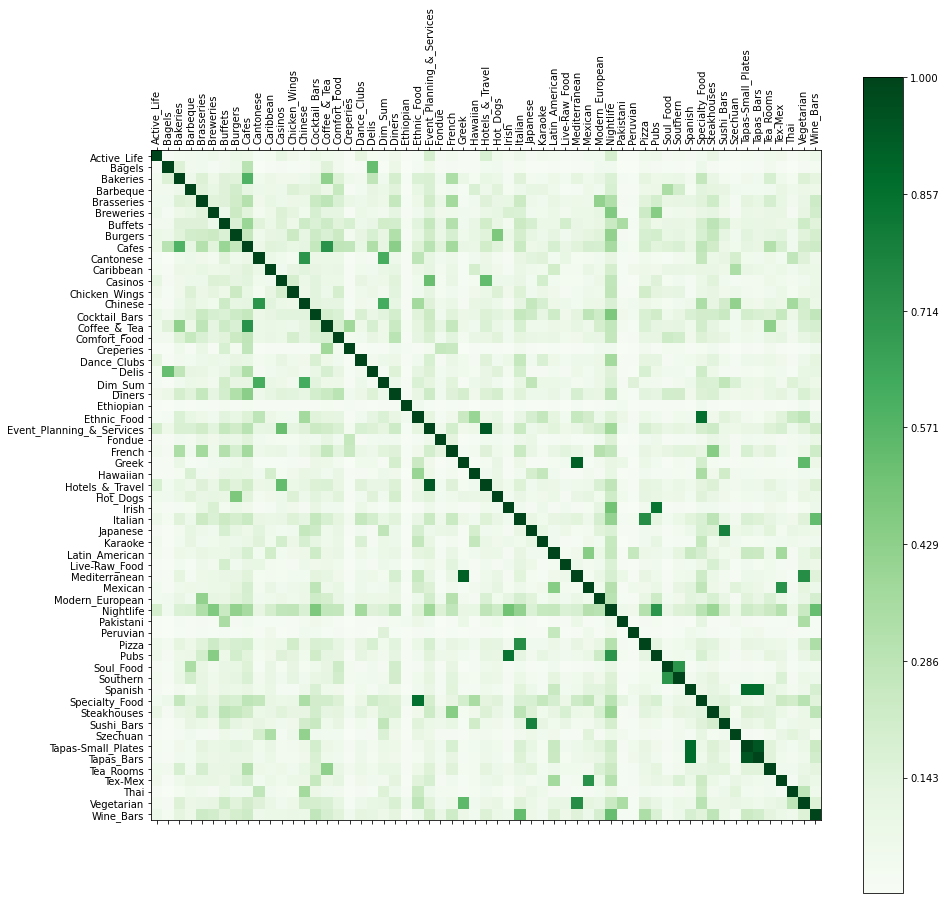

In [48]:
draw(similarity_if)

1. Change maxmium document frequency from 90% to 50%

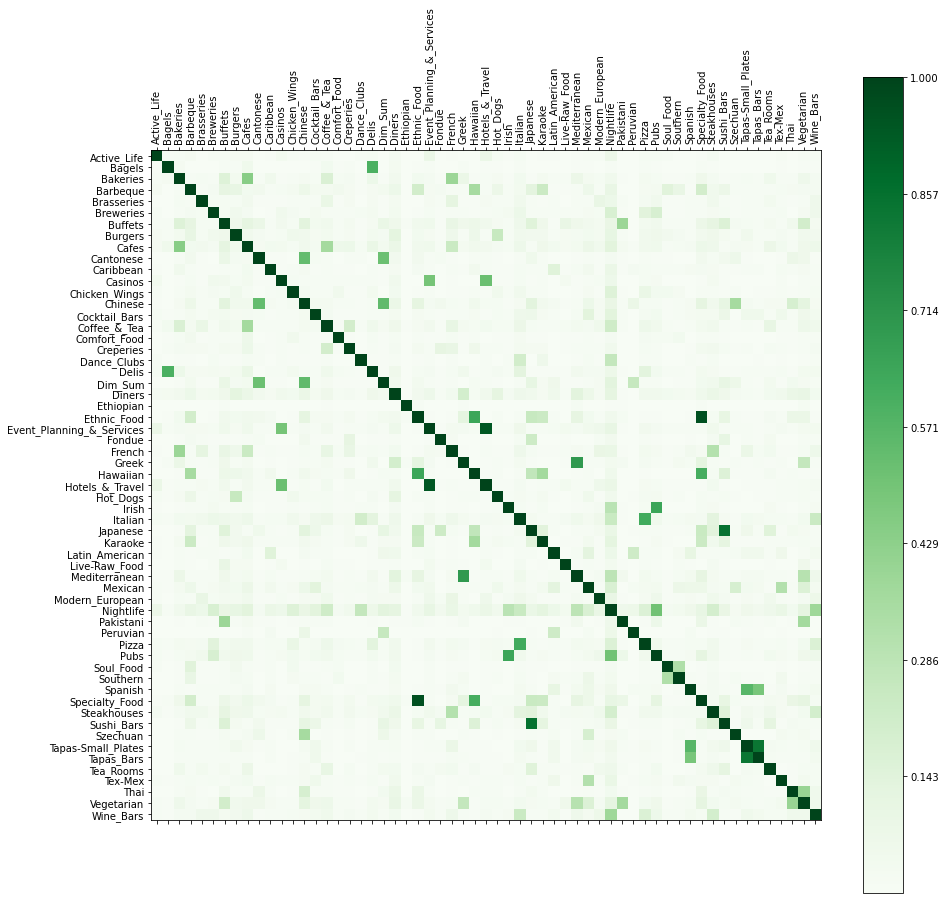

In [111]:
# max_df = .5
def vectorizer(contents, use_idf=False, min_df=2, max_df=0.5, stop_words=STOP_WORDS):
    vectorizer = TfidfVectorizer(stop_words=stop_words, # from nltk
                                 encoding='utf-8',
                                 strip_accents='unicode',
          a                       lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    id2words ={}
    for i,word in enumerate(vectorizer.get_feature_names()):
        id2words[i] = word
    return matrix,np.vstack([cosine_similarity(val, matrix)
                             for val in matrix]),id2words
%matplotlib inline

def draw(matrix ):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='Greens')
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.set_xticklabels(cuisines, rotation='vertical')
    ax.set_yticklabels(cuisines)
    fig.colorbar(cax, ticks=np.linspace(0,1,8))
    fig.set_size_inches(15, 15)
    plt.show()
    
matrix_if,similarity_if, id2words = vectorizer(contents,use_idf=False)
draw(similarity_if)

2.Implement IDF weighiting 

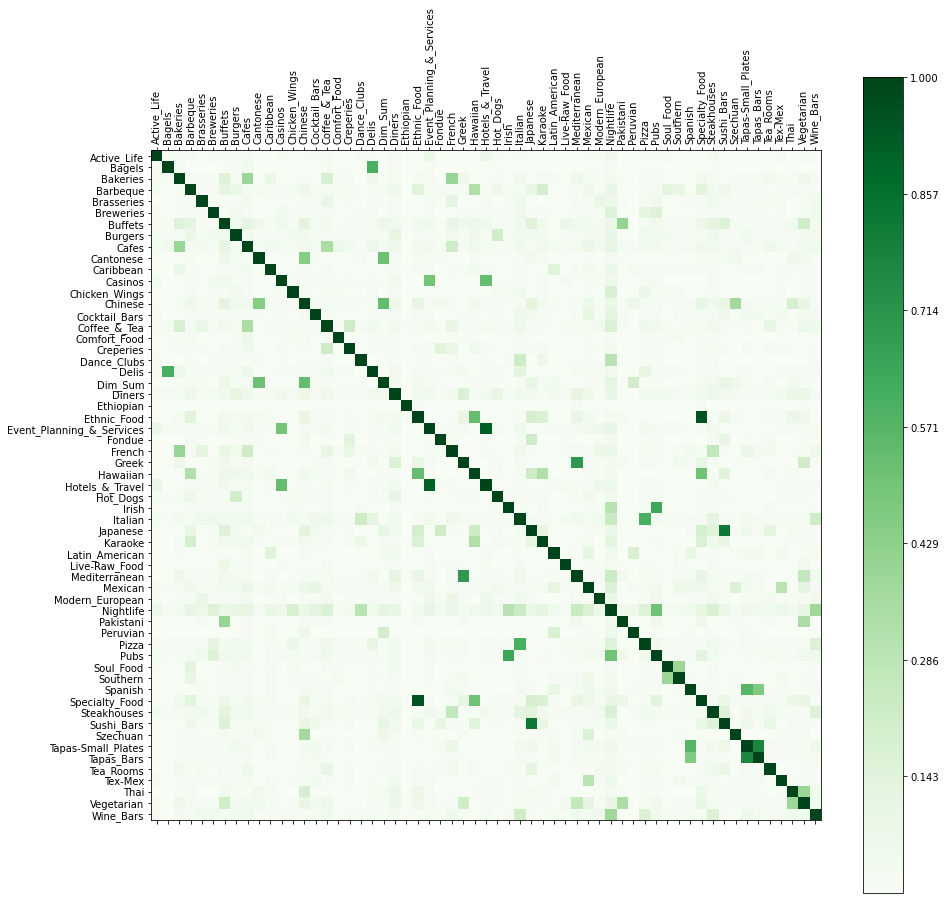

In [120]:
# max_df = .5， IDA weighting
def vectorizer(contents, use_idf=True, min_df=2, max_df=0.5, stop_words=STOP_WORDS):
    vectorizer = TfidfVectorizer(stop_words=stop_words, # from nltk
                                 encoding='utf-8',
                                 strip_accents='unicode',
                                 lowercase=True,
                                 use_idf=use_idf,
                                 max_features=10000,
                                 min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(contents)
    id2words ={}
    for i,word in enumerate(vectorizer.get_feature_names()):
        id2words[i] = word
    return matrix,np.vstack([cosine_similarity(val, matrix)
                             for val in matrix]),id2words
%matplotlib inline

def draw(matrix ):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='Greens')
    ax.set_xticks(np.arange(matrix.shape[1]), minor=False)
    ax.set_yticks(np.arange(matrix.shape[0]), minor=False)
    ax.set_xticklabels(cuisines, rotation='vertical')
    ax.set_yticklabels(cuisines)
    fig.colorbar(cax, ticks=np.linspace(0,1,8))
    fig.set_size_inches(15, 15)
    plt.show()
    
matrix_if,similarity_if, id2words = vectorizer(contents,use_idf=True)
draw(similarity_if)

3. Implement LDA to mine topices between cuisines

c:\users\besth\appdata\local\programs\python\python38\lib\site-packages\gensim\models\ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


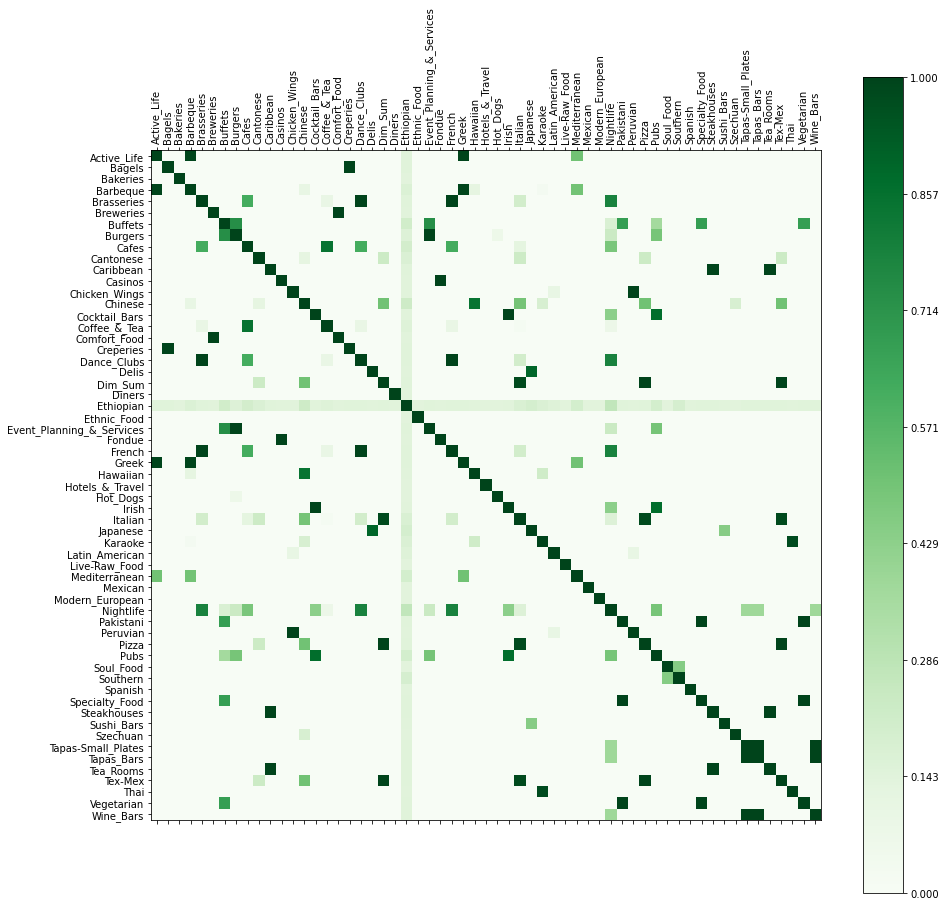

In [116]:
##Using LDA

# matrix_if, similarity_if, id2words = vectorizer(contents, use_idf=False)
vectorizer = TfidfVectorizer(stop_words=STOP_WORDS, # from nltk
                             encoding='utf-8',
                             strip_accents='unicode',
                             lowercase=True,
                             use_idf=True,
                             max_features=10000,
                             min_df=2, max_df=0.5)
matrix = vectorizer.fit_transform(contents)
id2words ={}
for i,word in enumerate(vectorizer.get_feature_names()):
    id2words[i] = word
# include LDA
corpus = matutils.Sparse2Corpus(matrix, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=50,
                                id2word=id2words,
                                alpha='auto',
                                eval_every=5) # can play around with number of topics
doc_topics = lda.get_document_topics(corpus)

topic_pro = np.zeros((len(cuisines), len(doc_topics)))
idx = 0
for val in doc_topics:
    for jdx, pro in val:
        topic_pro[idx][jdx] = pro
    idx += 1
%matplotlib inline
matrix = pd.DataFrame(np.vstack([cosine_similarity(val.reshape(1, -1), topic_pro) for val in topic_pro]))
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

4.Computing similarity of individual reviews before aggregating.


In [128]:
from gensim import models
from gensim import matutils
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, Birch, SpectralClustering, DBSCAN, AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

In [129]:
##computing similarity at the document (review) level before aggregating.
matrix_if3, similarity_if3, id2words3 = vectorizer(contents, use_idf=True, min_df=2, max_df=0.5)


In [130]:
corpus = matutils.Sparse2Corpus(matrix_if3, documents_columns=False)
lda = models.ldamodel.LdaModel(corpus, 
                                num_topics=50,
                                id2word=id2words2,
                                alpha='auto',
                                eval_every=5)
doc_topics = lda.get_document_topics(corpus)

c:\users\besth\appdata\local\programs\python\python38\lib\site-packages\gensim\models\ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [131]:
cuisine_matrix = [] #similarity of topics
# computing cosine similarity matrix
for i, doc_a in enumerate(doc_topics):
    #print (i)
    sim_vecs = []
    for j , doc_b in enumerate(doc_topics):
        w_sum = 0
        if ( i <= j ):
            norm_a = 0
            norm_b = 0

            for (my_topic_b, weight_b) in doc_b:
                norm_b = norm_b + weight_b*weight_b

            for (my_topic_a, weight_a) in doc_a:
                norm_a = norm_a + weight_a*weight_a
                for (my_topic_b, weight_b) in doc_b:
                    if ( my_topic_a == my_topic_b ):
                        w_sum = w_sum + weight_a*weight_b

            norm_a = math.sqrt(norm_a)
            norm_b = math.sqrt(norm_b)
            denom = (float) (norm_a * norm_b)
            if denom < 0.0001:
                w_sum = 0
            else:
                w_sum = w_sum/(denom)
        else:
            w_sum = cuisine_matrix[j][i]
        sim_vecs.append(w_sum)

    cuisine_matrix.append(sim_vecs)
    cuisine_matrix

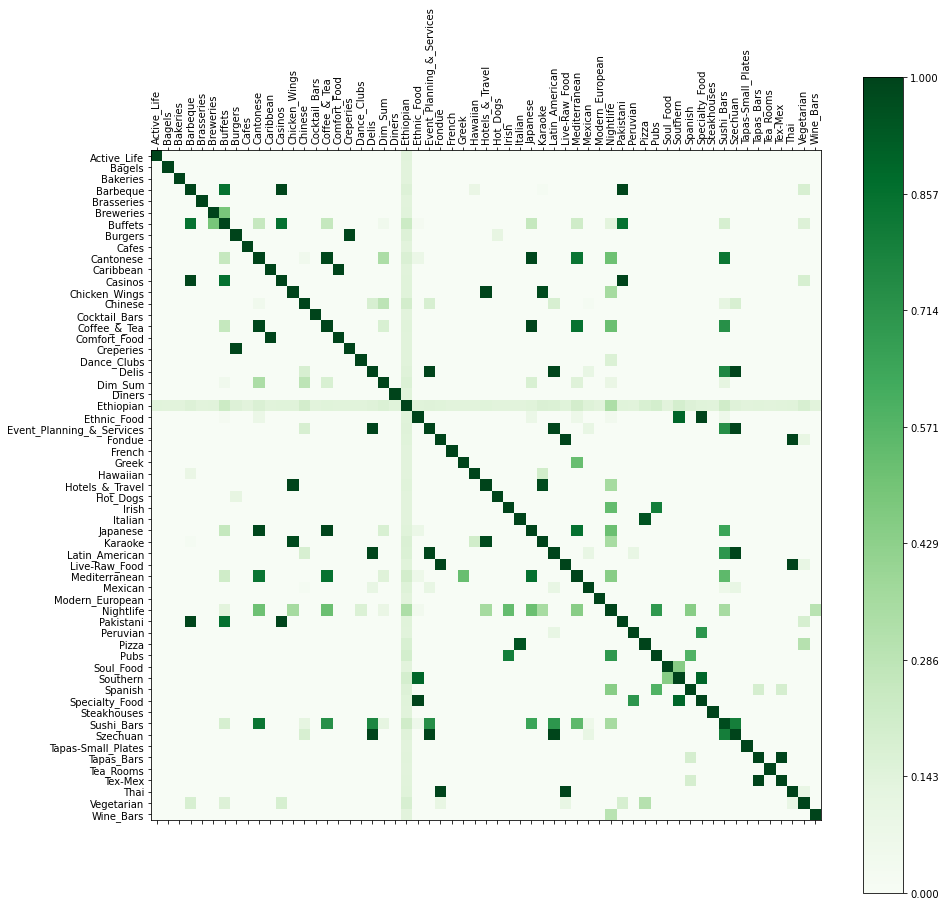

In [132]:
%matplotlib inline
matrix = pd.DataFrame(cuisine_matrix)
matrix.columns = cuisines
matrix.index = cuisines
draw(matrix)

TASK 2.3 Using LDA as clustering and assign categories into topics

1.KMeans Clustering

In [216]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
cluster_colors = {-1:'firebrick', 0:'darkviolet', 1:'fuchsia', 2:'orangered', 3:'cornflowerblue', 4:'olive', 5:'greenyellow', 
            6:'springgreen', 7:'darkslategrey', 8:'orange', 9:'darkblue', 10:'limegreen',
            11:'aqua', 12:'saddlebrown', 13:'yellow', 14:'dodgerblue', 15:'coral',
            16:'mediumslateblue', 17:'brown', 18:'seagreen', 19:'lightslategrey', 20:'cyan'}
def plot_mds(model, dist):
    %matplotlib inline
    
    clusters = model.labels_.tolist() 
    c_idx = list(set(clusters)) # list(range(0, len(set(clusters))))
    c_list = ["cluster "+ str(i) for i in c_idx]
    cluster_names = dict(zip(c_idx, c_list))
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
    xs, ys = pos[:, 0], pos[:, 1]
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=cuisines))

    #group by cluster
    groups = df.groupby('label')
    
    # set up plot
    fig, ax = plt.subplots(figsize=(15, 10)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_names[name], color=mcolors.to_hex(cluster_colors[name]),
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  # show legend with only 1 point

    # add label in x,y position with the label as the film title
    for i in range(len(df)):
        ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.loc[i]['title'], size=8)

    plt.show()  # show the plot


In [217]:
mtx = matrix_if
X = mtx.toarray() 
dist = 1 - similarity_if

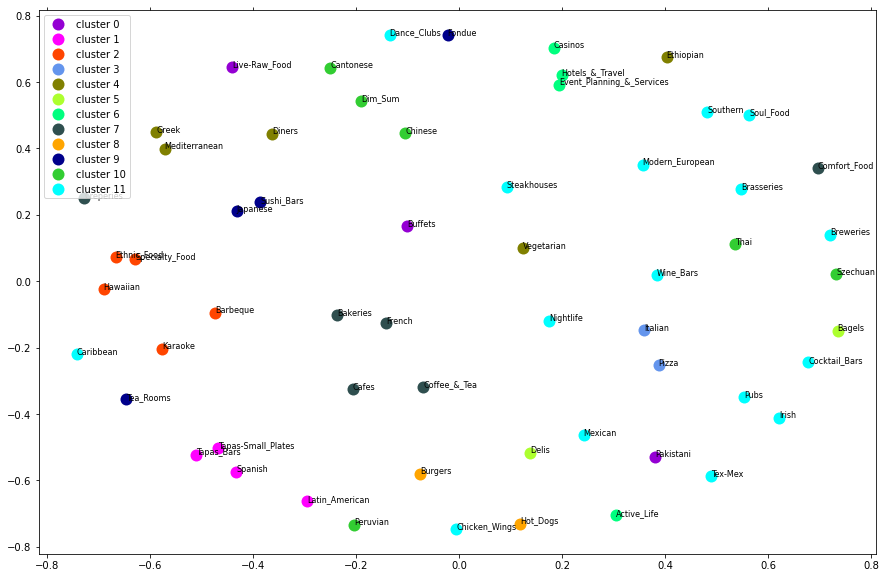

Wall time: 1.51 s


In [232]:
%%time
num_clusters = 12
SEED = 123
km5 = KMeans(n_clusters=num_clusters, random_state=SEED).fit(mtx)
plot_mds(km5, dist)

2. Hierarchical Clustering/ Dendrogram

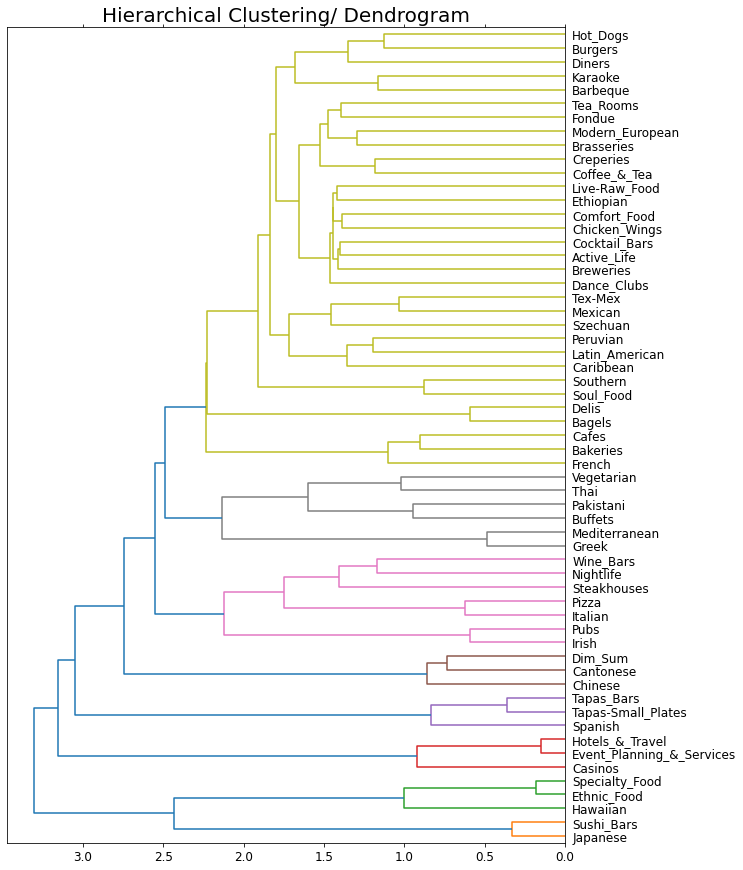

In [231]:
from scipy.cluster.hierarchy import ward, dendrogram

dist = 1 - similarity_if
linkage_matrix = ward(dist)
fig, ax = plt.subplots(figsize=(10, 15)) # set size
ax = dendrogram(linkage_matrix, orientation="left", labels=cuisines);

plt.tick_params(
    axis= 'x',   labelsize = 12,    
    which='both',     
    bottom='off',     
    top='off',        
    labelbottom='off')
plt.title('Hierarchical Clustering/ Dendrogram', fontsize=20)
plt.tick_params(axis='y',  labelsize=12)
plt.show() #show plot with tight layout